## Introduction


In [46]:
library(tidyverse)
library(tidymodels)
library(cowplot)

In [57]:
player_data <- read_csv("https://raw.githubusercontent.com/PraiseBeTheSun/DSCI-100-GROUP-PROJECT/refs/heads/main/data/players.csv")
session_data <- read_csv("https://raw.githubusercontent.com/PraiseBeTheSun/DSCI-100-GROUP-PROJECT/refs/heads/main/data/sessions.csv")

player_data <- player_data |>
filter(Age != is.na(Age)) |>
mutate(subscribe = as.factor(subscribe),
       gender = as.factor(gender),
       experience = as.factor(experience))

player_means <- player_data |>
summarize(mean_played_hours = mean(played_hours, na.rm = TRUE),
          mean_age = mean(Age, na.rm = TRUE))

player_means |>
pivot_longer(cols = c(mean_played_hours, mean_age), names_to = "variable", values_to = "mean_value")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


variable,mean_value
<chr>,<dbl>
mean_played_hours,5.904639
mean_age,21.139175


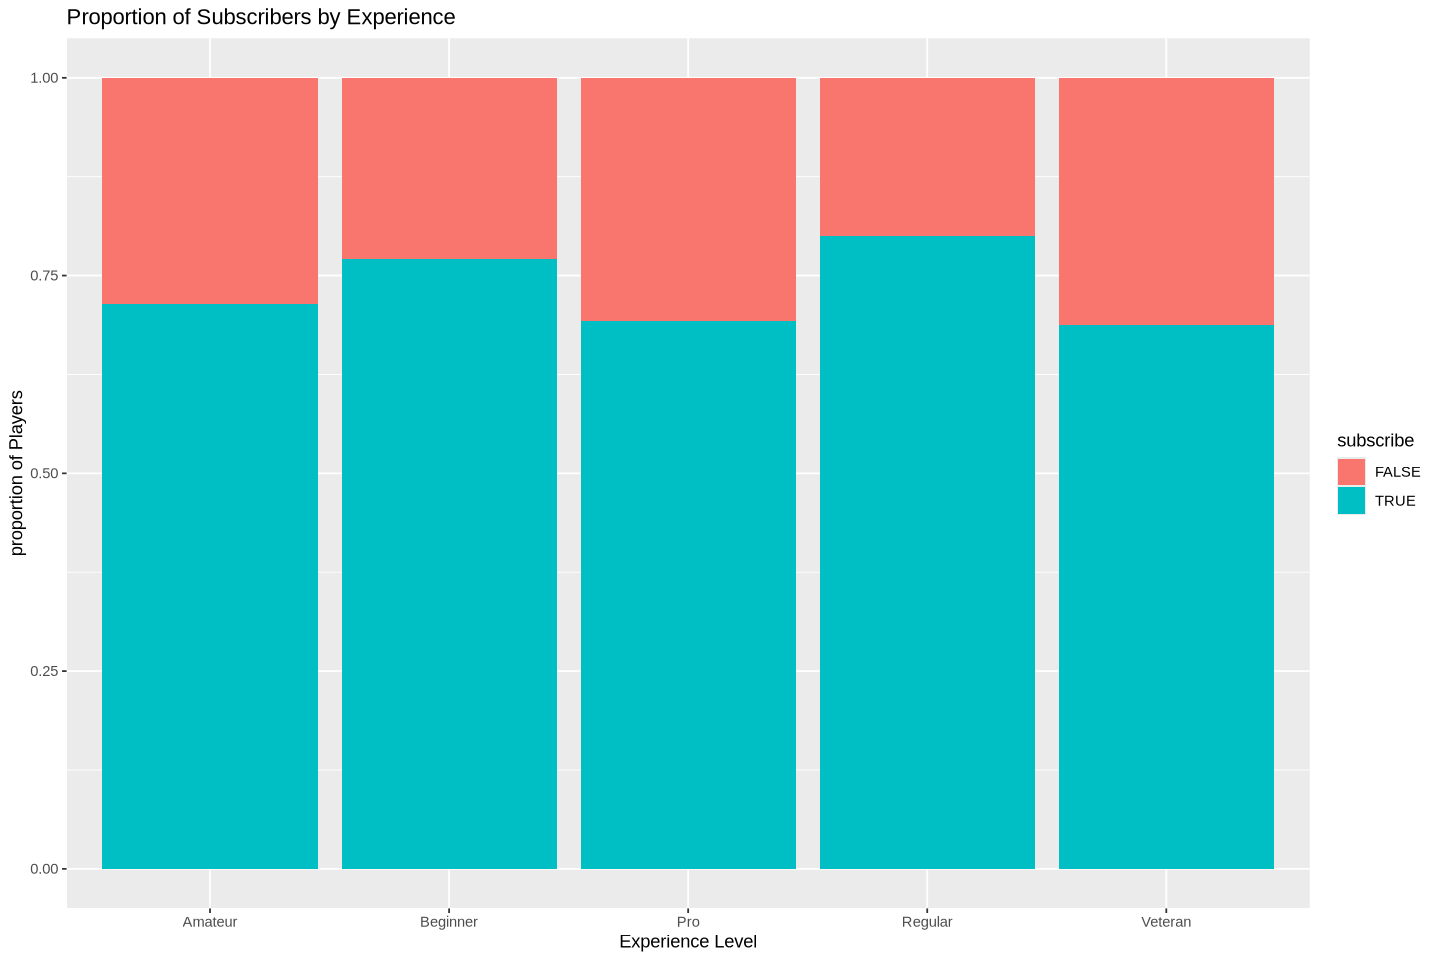

In [58]:
options(repr.plot.width = 12, repr.plot.height = 8)
ggplot(player_data, aes(x = experience, fill = subscribe)) +
geom_bar(position = "fill") +
labs(title = "Proportion of Subscribers by Experience", x = "Experience Level", y = "proportion of Players")

### VFold

In [59]:
set.seed(1)
player_split <- initial_split(player_data, prop = 0.75, strata = subscribe)
player_train <- training(player_split)
player_test <- testing(player_split)

player_vfold <- vfold_cv(player_train, v = 5, strata = subscribe)

### KNN Classification Models

In [60]:
k_vals <- tibble(neighbors = seq(from = 1, to = 80, by = 3))

#manual forward selection
knn_recipe_age <- recipe(subscribe ~ Age, data = player_train) |>
                step_normalize(all_predictors())

knn_recipe_experience <- recipe(subscribe ~ experience, data = player_train)

knn_recipe_both <- recipe(subscribe ~ Age + experience, data = player_train) |>
                step_normalize(Age)

knn_recipe_hours <- recipe(subscribe ~ played_hours, data = player_train) |>
                step_normalize(played_hours)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

age_tune <- workflow() |>
            add_recipe(knn_recipe_age) |>
            add_model(knn_spec) |>
            tune_grid(resamples = player_vfold, grid = k_vals) |>
            collect_metrics() |>
            filter(.metric == "accuracy") 

experience_tune <- workflow() |>
            add_recipe(knn_recipe_experience) |>
            add_model(knn_spec) |>
            tune_grid(resamples = player_vfold, grid = k_vals) |>
            collect_metrics() |>
            filter(.metric == "accuracy") 

both_tune <- workflow() |>
            add_recipe(knn_recipe_both) |>
            add_model(knn_spec) |>
            tune_grid(resamples = player_vfold, grid = k_vals) |>
            collect_metrics() |>
            filter(.metric == "accuracy") 


### KNN Tune Model Plots

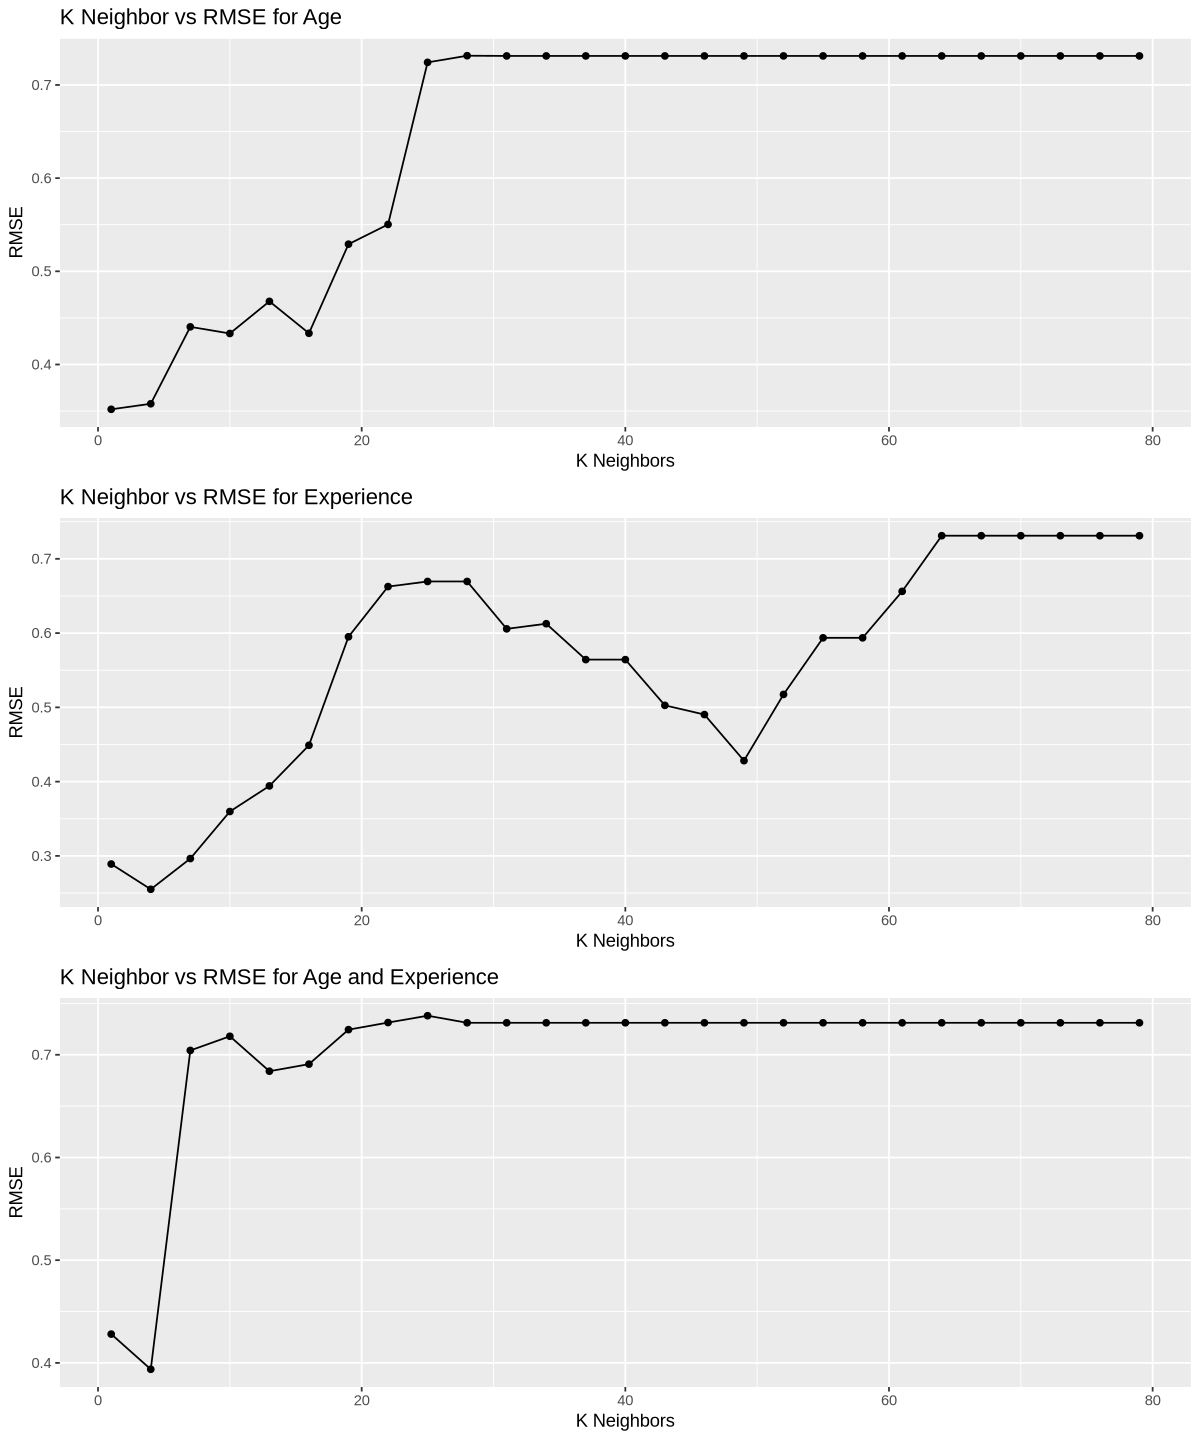

In [61]:
options(repr.plot.width = 10, repr.plot.height = 12)
age_tune_plot <- age_tune |>
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(x = "K Neighbors", y = "RMSE") +
                ggtitle("K Neighbor vs RMSE for Age")

experience_tune_plot <- experience_tune |>
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(x = "K Neighbors", y = "RMSE") +
                ggtitle("K Neighbor vs RMSE for Experience")

both_tune_plot <- both_tune |>
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(x = "K Neighbors", y = "RMSE") +
                ggtitle("K Neighbor vs RMSE for Age and Experience")

plot_grid(age_tune_plot,
          experience_tune_plot,
          both_tune_plot, ncol = 1)
